In [1]:
from pathlib import Path

DATA_PATH = Path('/mnt/wsl/PHYSICALDRIVE1/data/unsplash/edited')
DATA = sorted(DATA_PATH.glob('*'))
BINS = 32
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.00001

In [2]:
import torch
device = torch.device("cuda:0")

In [3]:

from torch.utils.data import DataLoader, random_split
from editor.training import HistogramDataset

dataset = HistogramDataset(DATA, expected_edit_count=10, bin_count=BINS)
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=32)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=32)

  5%|▍         | 1232/24997 [00:00<00:05, 4044.85it/s]

Failed to open /mnt/wsl/PHYSICALDRIVE1/data/unsplash/edited/0LnXtS8DUZI/3.jpg
Failed to open /mnt/wsl/PHYSICALDRIVE1/data/unsplash/edited/0OqCRbwWu6g/1.jpg


100%|██████████| 24997/24997 [00:06<00:00, 3991.28it/s]


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HistogramRestorationNet(nn.Module):
    def __init__(self):
        super(HistogramRestorationNet, self).__init__()

        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.conv3 = nn.Conv3d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        
        # Adjusted residual connections with proper downsampling and channel matching
        self.res1 = nn.Sequential(
            nn.Conv3d(16, 32, 1, stride=1, padding=0),  # Match channels
            nn.BatchNorm3d(32),
            nn.MaxPool3d(2)  # Downsample to match size
        )
        self.res2 = nn.Sequential(
            nn.Conv3d(32, 64, 1, stride=1, padding=0),  # Match channels
            nn.BatchNorm3d(64),
            nn.MaxPool3d(2)  # Downsample to match size
        )

        self.fc1 = nn.Linear(64 * 4 * 4 * 4, 512)
        self.fc_bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 32 * 32 * 32)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool3d(x, 2)

        # Apply first adjusted residual connection
        res = self.res1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool3d(x, 2)
        x += res  # Add adjusted residual

        # Apply second adjusted residual connection
        res = self.res2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool3d(x, 2)
        x += res  # Add adjusted residual

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = self.fc2(x)

        # Reshape back to the histogram shape
        x = x.view(-1, 32, 32, 32)

        return x


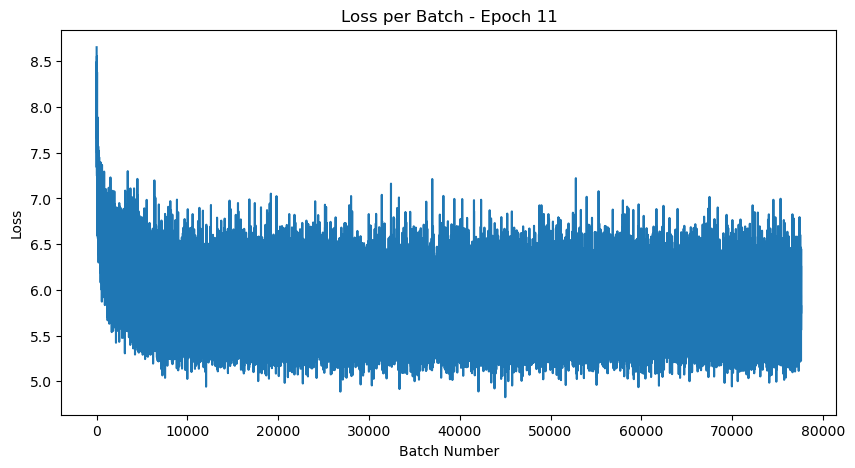

 37%|███▋      | 2753/7491 [02:09<03:43, 21.24it/s]


KeyboardInterrupt: 

In [5]:
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

def init_weights_he(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

model = HistogramRestorationNet().to(device).double()
model.apply(init_weights_he)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.2)
loss_function = torch.nn.KLDivLoss(reduction='batchmean')

losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for edited_histogram, original_histogram in tqdm(train_dataloader):
        edited_histogram = edited_histogram.double().to(device)
        original_histogram = original_histogram.squeeze(1).double().to(device)
        
        optimizer.zero_grad()
        
        predicted_original = model(edited_histogram)
        predicted_original = torch.clamp(predicted_original, 1)
        predicted_original /= predicted_original.sum()
        loss = loss_function(torch.log(predicted_original), original_histogram)
        
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        losses.append(loss.item())
        if len(losses) % 200 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(10, 5))
            plt.plot(losses, label='Training Loss')
            plt.xlabel('Batch Number')
            plt.ylabel('Loss')
            # plt.yscale('log')
            plt.title(f'Loss per Batch - Epoch {epoch + 1}')
            plt.show()
    scheduler.step()

In [6]:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [7]:
model = HistogramRestorationNet().to(device)
model.load_state_dict(torch.load('model_state_dict.pth'))
model.eval()

HistogramRestorationNet(
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res1): Sequential(
    (0): Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Ma

In [8]:
loader = iter(test_dataloader)

In [12]:
from editor.ploting import plot_histograms


edited_histogram, original_histogram = next(loader)
edited_histogram = edited_histogram.to(device)
original_histogram = original_histogram.to(device)
predicted_original = model(edited_histogram)
predicted_original = torch.clamp(predicted_original, 1)
predicted_original /= predicted_original.sum()
plot_histograms([
    original_histogram.cpu().numpy().squeeze(),
    edited_histogram.cpu().numpy().squeeze(),
    predicted_original.cpu().detach().numpy().squeeze()
])
